In [1218]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [1219]:
from importlib import reload
plt=reload(plt)

### settings

In [1220]:
epsilon = 0.0005

In [1221]:
def fdiv(a, b):
    return 1 if not b else a / b

In [1222]:
def roundf(val):
    precision = 3
    return round(val, precision)

## 1. Відкрити та зчитати дані з наданого файлу.

### Файл містить три стовпчики:
- а. Фактичне значення цільової характеристики.
- b. Результат передбачення моделі №1 у вигляді ймовірності приналежності об'єкту до класу 0.
- c. Результат передбачення моделі №2 у вигляді ймовірності приналежності об'єкту до класу 1.

In [1223]:
df = pd.read_csv('KM-12-3.csv')
df

,GT,Model_1_0,Model_2_1
0,1,0.213394,0.999988
1,0,0.996161,0.003391
2,0,1.000000,0.000896
3,0,0.999142,0.000275
4,0,0.849776,0.003276
...,...,...,...
4395,0,0.945974,0.000088
4396,1,0.060282,0.913194
4397,1,0.003474,0.984063
4398,1,0.009708,0.996404


## Додатковий пункт (1)

Оскільки нам необхідно буде порівнювати якості моделей, то моделі мають надавати ймовірність належності об'єктів до однакового класів, а не для різних. В силу того, що за умовою ми маємо моделі бінарної класифікації, визначимо нові стовпці Model_1_1 та Model_2_1:

In [1224]:
df['Model_1_1'] = abs(df['Model_1_0'] - 1)
df['Model_2_0'] = abs(df['Model_2_1'] - 1)
df = df.reindex(columns=sorted(df.columns))
df

,GT,Model_1_0,Model_1_1,Model_2_0,Model_2_1
0,1,0.213394,0.786606,0.000012,0.999988
1,0,0.996161,0.003839,0.996609,0.003391
2,0,1.000000,0.000000,0.999104,0.000896
3,0,0.999142,0.000858,0.999725,0.000275
4,0,0.849776,0.150224,0.996724,0.003276
...,...,...,...,...,...
4395,0,0.945974,0.054026,0.999912,0.000088
4396,1,0.060282,0.939718,0.086806,0.913194
4397,1,0.003474,0.996526,0.015937,0.984063
4398,1,0.009708,0.990292,0.003596,0.996404


## 2. Визначити збалансованість набору даних. Вивести кількість об'єктів кожного класу.

In [1199]:
df['GT'].value_counts()

1    2200
0    2200
Name: GT, dtype: int64

Як можна бачити, кількість елементів-представників кожного класу є однаковою, тому вибірка є сбалансованою

## 3. Для зчитаного набору даних виконати наступні дії:
- a. Обчислити всі метрики (**Accuracy, Precision, Recall, F-Scores, Matthews Corellation Coeficient, Balanced Accuracy, Youden's J statistics, Area Under Curve for Precision-Recall Curve, Area Under Curve for Receiver Operation Curve**) для кожної моделі при різних значеннях порогу класифікатора (крок зміни порогу обрано самостійно: Δ = 0.001)
- b. Збудувати на одному графіку в одній координатній системі (*величина порогу; значення метрики) графіки усіх обчислених метрик, відмітивши певним чином максимальне значення кожної з них.
- c. Збудувати в координатах (*значення оцінки класифікаторів; кількість об'єктів кожного класу*) окремі для кожного класу графіки кількості об'єктів та відмітити вертикальними лініями оптимальні пороги відсічення кожної метрики.
- d. Збудувати для кожного класифікатору **PR-криву** та **ROC-криву**, показавши графічно на них значення оптимального порогу.

In [1252]:
threshold = np.linspace(-epsilon, 1+epsilon, int(1 / epsilon))
fact_value = df.columns[0]
models = df.columns[2::2].values

def calc(df, model, threshold):
    model_exmp = dict()
    
    for t in tqdm(threshold):
        TP = len(df[(df[fact_value] == 1) & (df[model] >= t)])
        FP = len(df[(df[fact_value] == 0) & (df[model] >= t)])
        FN = len(df[(df[fact_value] == 1) & (df[model] < t)])
        TN = len(df[(df[fact_value] == 0) & (df[model] < t)])
        
        accuracy = fdiv((TP + TN), (TP + TN + FP + FN))
#         accuracy_sklearn = accuracy_score(df['GT'], df[model] >= t)
        precision = fdiv(TP, (TP + FP))
#         precision_sklearn = precision_score(df['GT'], df[model] >= t)
        recall = fdiv(TP, (TP + FN))
#         recall_sklearn = recall_score(df['GT'], df[model] >= t)
        f_score = fdiv(2 * precision * recall, (precision + recall))
#         f_score_sklearn = f1_score(df['GT'], df[model] >= t
        
        try:
            MCC = (TP * TN - FP * FN) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        except ZeroDivisionError:
            MCC = 0
            
#         MCC_sklearn = matthews_corrcoef(df['GT'], df[model] >= t)
        
        sensitivity = fdiv(TP, (TP + FN))
        specificity = fdiv(TN, (TN + FP))

        BA = (sensitivity + specificity) / 2
#         BA_sklearn = balanced_accuracy_score(df['GT'], df[model] >= t)

        J_statistics = sensitivity + specificity - 1

        model_exmp.update({'accuracy': model_exmp.get('accuracy', []) + [accuracy]})
        model_exmp.update({'precision': model_exmp.get('precision', []) + [precision]})
        model_exmp.update({'recall': model_exmp.get('recall', []) + [recall]})
#         model_exmp.update({'precision_sklearn': model_exmp.get('precision_sklearn', []) + [precision_sklearn]})
#         model_exmp.update({'recall_sklearn': model_exmp.get('recall_sklearn', []) + [recall_sklearn]})
        model_exmp.update({'f_score': model_exmp.get('f_score', []) + [f_score]})
        model_exmp.update({'MCC': model_exmp.get('MCC', []) + [MCC]})
        model_exmp.update({'specificity': model_exmp.get('specificity', []) + [specificity]})
        model_exmp.update({'sensitivity': model_exmp.get('sensitivity', []) + [sensitivity]})
        model_exmp.update({'BA': model_exmp.get('BA', []) + [BA]})
        model_exmp.update({'J_statistics': model_exmp.get('J_statistics', []) + [J_statistics]})

    FPR = [*map(lambda x: 1 - x, model_exmp['specificity'])]
    TPR = model_exmp['sensitivity']
    
    PRC_AUC = auc(model_exmp['recall'], model_exmp['precision'])
    ROC_AUC = auc(FPR, TPR)
    
    Joudens_index = max(model_exmp['J_statistics'])
    
    model_exmp["Youden's index"] = Joudens_index
    model_exmp['PRC_AUC'] = PRC_AUC
    model_exmp['ROC_AUC'] = ROC_AUC
    
    return model_exmp


model_1 = dict({'name': models[0], 'model': calc(df, models[0], threshold)})
model_2 = dict({'name': models[1], 'model': calc(df, models[1], threshold)})

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 371.78it/s]


a. Обчислити всі метрики (**Accuracy, Precision, Recall, F-Scores, Matthews Corellation Coeficient, Balanced Accuracy, Youden's J statistics, Area Under Curve for Precision-Recall Curve, Area Under Curve for Receiver Operation Curve**) для кожної моделі при різних значеннях порогу класифікатора (крок зміни порогу обрано самостійно: Δ = 0.001)

In [1253]:
def calc_metrics(model_1, model_2):
    for model in (model_1, model_2):
        print(f"Model: {model['name']}", end='\n\n')

        for k,v in model['model'].items():
            if k not in ['specificity', 'sensitivity']:
                print(f'{k} (mean): {roundf(sum(v) / len(v))}') if isinstance(v, list) else print(f'{k}: {roundf(v)}')

        print('\n\n') if model != model_2 else print('')

calc_metrics(model_1, model_2)

Model: Model_1_1

accuracy (mean): 0.92
precision (mean): 0.949
recall (mean): 0.909
f_score (mean): 0.915
MCC (mean): 0.858
BA (mean): 0.92
J_statistics (mean): 0.84
Youden's index: 0.983
PRC_AUC: 0.996
ROC_AUC: 0.996



Model: Model_2_1

accuracy (mean): 0.977
precision (mean): 0.981
recall (mean): 0.975
f_score (mean): 0.975
MCC (mean): 0.957
BA (mean): 0.977
J_statistics (mean): 0.955
Youden's index: 0.98
PRC_AUC: 0.992
ROC_AUC: 0.996



b. Збудувати на одному графіку в одній координатній системі (*величина порогу; значення метрики*) графіки усіх обчислених метрик, відмітивши певним чином максимальне значення кожної з них.

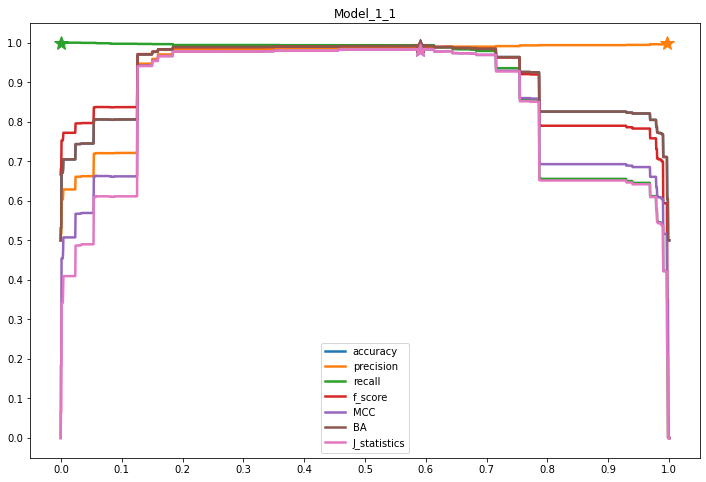

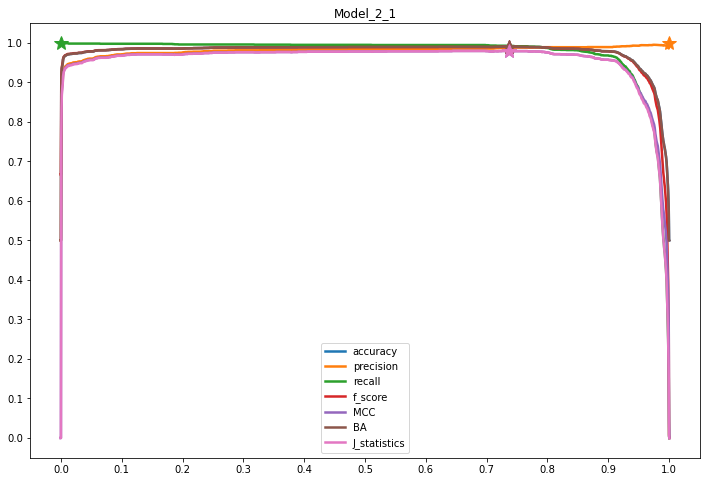

In [1254]:
def viz_metrics(model_1, model_2):
    for model in (model_1, model_2):
        plt.figure(figsize=(12,8))
        ax = plt.gca()
        for k,v in model['model'].items():
            if isinstance(v, list) and k not in ['specificity', 'sensitivity']:
                color = next(ax._get_lines.prop_cycler)['color']
                plt.plot(threshold, v, label=str(k), linewidth=2.5, color=color) 
                plt.plot(threshold[v.index(max(v))], max(v), marker='*', markersize=15, color=color)
                plt.xticks(np.arange(0, 1.01, .1))
                plt.yticks(np.arange(0, 1.01, .1))  
        plt.title(model['name'])
        plt.legend()
        plt.show()

viz_metrics(model_1, model_2)

c. Збудувати в координатах (*значення оцінки класифікаторів; кількість об'єктів кожного класу*) окремі для кожного класу графіки кількості об'єктів та відмітити вертикальними лініями оптимальні пороги відсічення кожної метрики.

Варто зауважити, що, нас не змушують забезпечувати, наприклад, precision-recall trade-off, тобто балансувати конкретними метриками для загального найкращого результату, тому у цьому пункті необхідно знайти та відмітити оптимальні пороги для кожної метрики окремо. Виходячи з графіків, отриманих для двох моделей, можна взяти, наприклад, поріг, за якого значення кожної відповідної метрики буде >= 0.95

{'accuracy': 0.12618984492246121, 'precision': 0.15022586293146573, 'recall': -0.0005, 'f_score': 0.12618984492246121, 'MCC': 0.15022586293146573, 'BA': 0.12618984492246121, 'J_statistics': 0.15022586293146573}


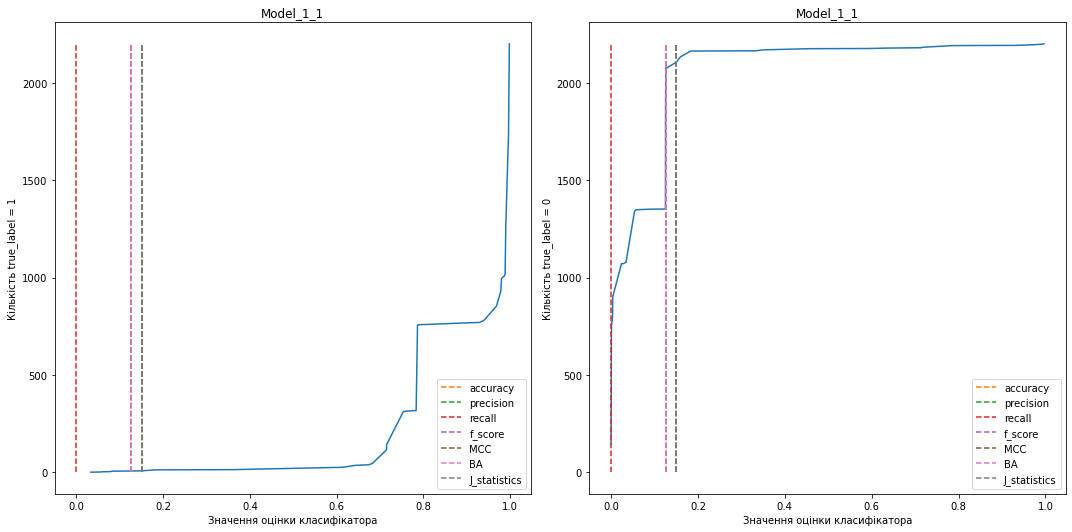

{'accuracy': 0.00350600300150075, 'precision': 0.020531515757878937, 'recall': -0.0005, 'f_score': 0.003005252626313156, 'MCC': 0.035053276638319156, 'BA': 0.00350600300150075, 'J_statistics': 0.03555402701350675}


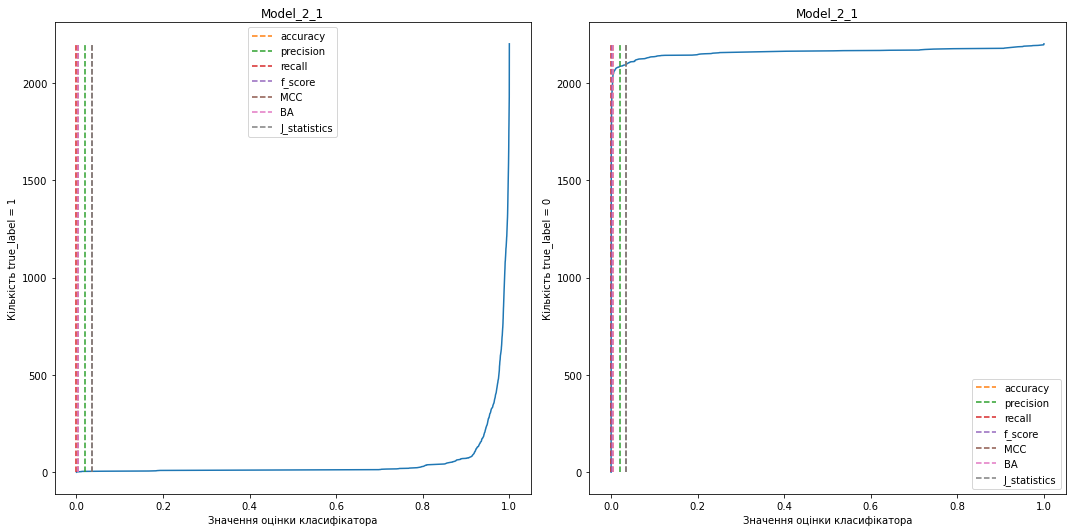

In [1255]:
def plot_model(model, metric_threshold):
    name = model['name']
    mod = df[[fact_value, name]].sort_values(by=[name])
    model_values = sorted(list(zip(mod.value_counts().keys(), mod.value_counts().tolist())), key=lambda x: float(x[0][1]))
    model_ones = dict([(el[0][1], el[1]) for el in model_values if el[0][0] == 1])
    model_zeros = dict([(el[0][1], el[1]) for el in model_values if el[0][0] == 0])

    counter = 0
    for k,v in model_ones.items():
        counter += model_ones.get(k)
        model_ones.update({k: counter})
    
    counter = 0
    for k,v in model_zeros.items():
        counter += model_zeros.get(k)
        model_zeros.update({k: counter})
    
    opt_metrics = dict()
    
    for metric, value in model['model'].items():
        if isinstance(value, list) and metric not in ['specificity', 'sensitivity']:
            pair = list(zip(threshold, value))
            pair = list(filter(lambda x: x[1] >= metric_threshold, pair))
            opt_metrics.update({metric: pair[0][0]})
    
    plt.figure(figsize=(15, 7.5))
    ax = plt.gca()

    def plot_opt_metrics(ax):
        for metric, threshold in opt_metrics.items():
            color = next(ax._get_lines.prop_cycler)['color']
            ax.plot(np.repeat(opt_metrics[metric], 10), np.linspace(0, list(model_ones.values())[-1], 10), color=color, ls='--', label=metric)
            plt.legend()
    print(opt_metrics)
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(list(model_ones.keys()), list(model_ones.values()))
    plot_opt_metrics(ax1) 
    plt.title(name)
    plt.xlabel('Значення оцінки класифікатора')
    plt.ylabel('Кількість true_label = 1')

    ax2 = plt.subplot(1, 2, 2)
    plt.plot(list(model_zeros.keys()), list(model_zeros.values()))
    plot_opt_metrics(ax2)
    plt.title(name)
    plt.xlabel('Значення оцінки класифікатора')
    plt.ylabel('Кількість true_label = 0')

    plt.tight_layout()
    plt.show()

plot_model(model_1, 0.95)
plot_model(model_2, 0.95)

d. Збудувати для кожного класифікатору **PR-криву** та **ROC-криву**, показавши графічно на них значення оптимального порогу.

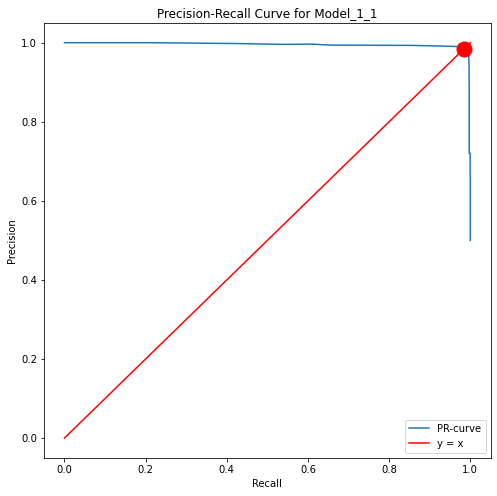

Model_1_1 PRC-AUC: 0.996


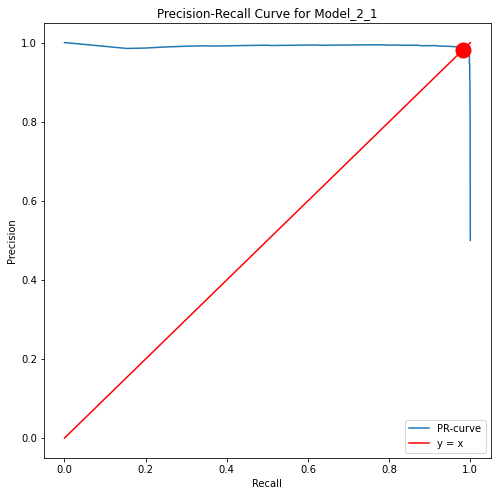

Model_2_1 PRC-AUC: 0.992


In [1256]:
def plot_prc(model_1, model_2):
    for mod in (model_1, model_2):
        name, model = mod['name'], mod['model']
        precision, recall = model['precision'], model['recall']
        PRC = [*zip(precision, recall)]
        
        for pair in PRC:
            if roundf(abs(pair[0] - pair[1])) <= 0.03:
                opt = pair
                break
#         print(opt)
        plt.figure(figsize=(8,8))
        plt.plot(recall, precision, label='PR-curve')
        avg = (opt[1] + opt[0]) / 2
        plt.plot(avg, avg, color='red', marker='o', markersize=15)
        plt.plot([0,1], [0,1], label='y = x', color='red')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {name}')
        plt.legend()
        plt.show()
        print(f'{name} PRC-AUC: {roundf(auc(recall, precision))}')

plot_prc(model_1, model_2)

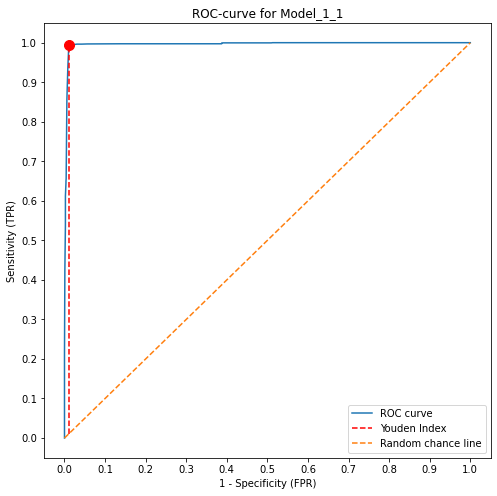

Model_1_1 ROC-AUC: 0.996


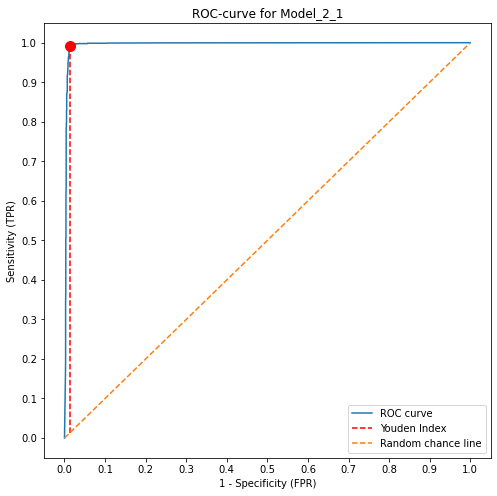

Model_2_1 ROC-AUC: 0.996


In [1257]:
def plot_roc(model_1, model_2): 
    for mod in (model_1, model_2):
        name, model = mod['name'], mod['model']
        FPR = [*map(lambda x: 1 - x, model['specificity'])]
        TPR = model['sensitivity']
        lst = list(map(lambda x: x[0]**2 + (1 - x[1])**2, list(zip(FPR, TPR))))
        opt = list(zip(FPR,TPR))[lst.index(min(lst))]
        plt.figure(figsize=(8,8))
        plt.xticks(np.arange(0, 1.01, .1))
        plt.yticks(np.arange(0, 1.01, .1))
        plt.xlabel('1 - Specificity (FPR)')
        plt.ylabel('Sensitivity (TPR)')
        plt.plot(FPR, TPR, label='ROC curve')
        plt.plot(opt[0], opt[1], color='red', marker='o', markersize=10)
        plt.plot(np.repeat(opt[0], 10), np.linspace(opt[0], 1, 10), color='red', ls='--', label='Youden Index')
        plt.plot([0,1], [0,1], ls='--', label='Random chance line')
        plt.title(f'ROC-curve for {name}')
        plt.legend()
        plt.show()
        print(f'{name} ROC-AUC: {roundf(auc(FPR, TPR))}')

plot_roc(model_1, model_2)

## 4. Зробити висновки щодо якості моделей, визначити кращу модель.

Обидві моделі показують хороші результати. Значення PRC-AUC майже однакові, а ROC-AUC співпадають з точністю до 3 знаків після коми. Проте, вочевидь, метрики для моделі №2 помітно кращі. Модель №1 поступається моделі №2 за всіма іншими метриками, окрім індекса Юдена, що можна помітити у наведених раніше обрахунках та візуалізаціях. Таким чином, у відносно близькій боротьбі, за сукупністю ознак бал переваги отримує Model_2  

## 5.

Створити новий набір даних, прибравши з початкового набору (50 + 10K)% об'єктів класу 1, вибраних випадковим чином. Параметр К представляє собою залишок від ділення місяця народження студента на чотири та має визначатися в програмі на основі дати народження студента, яка задана в програмі у вигляді текстової змінної формату **'DD-MM'**.

In [1258]:
K = '17-07'

In [1259]:
K = pd.to_datetime(K, format='%d-%m')
K = K.month
print(f'Місяць - {K}-ий')

Місяць - 7-ий


In [1260]:
n = 50 + 10*(K % 4)
print(f"Необхідно прибрати {n}% об'єктів класу 1")

Необхідно прибрати 80% об'єктів класу 1


In [1261]:
n = (n / 100) * len(df[df['GT'] == 1])

In [1262]:
print(f"Кількість об'єктів класу 1, що будуть видалені: {n}")

Кількість об'єктів класу 1, що будуть видалені: 1760.0


In [1263]:
random_sample = random.sample(df.index[df['GT'] == 1].tolist(), int(n))

In [1264]:
new_df = df.reindex(set(list(df.index.values)) - set(random_sample))

## 6. Вивести відсоток видалених об'єктів класу 1 та кількість елементів кожного класу після видалення.

In [1265]:
print(f"Відсоток видалених об'єктів класу 1: {100 * n / len(df[df['GT'] == 1])}%")

Відсоток видалених об'єктів класу 1: 80.0%


Кількість елементів кожного класу після видалення:

In [1266]:
new_df['GT'].value_counts()

0    2200
1     440
Name: GT, dtype: int64

## 7. Виконати дії п.3 для нового набору даних.

- 7.a

In [1267]:
model_1a = dict({'name': models[0], 'model': calc(new_df, models[0], threshold)})
model_2a = dict({'name': models[1], 'model': calc(new_df, models[1], threshold)})

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 422.36it/s]


In [1273]:
calc_metrics(model_1a, model_2a)

Model: Model_1_1

accuracy (mean): 0.927
precision (mean): 0.86
recall (mean): 0.91
f_score (mean): 0.853
MCC (mean): 0.836
BA (mean): 0.92
J_statistics (mean): 0.841
Youden's index: 0.978
PRC_AUC: 0.979
ROC_AUC: 0.994



Model: Model_2_1

accuracy (mean): 0.978
precision (mean): 0.913
recall (mean): 0.972
f_score (mean): 0.937
MCC (mean): 0.928
BA (mean): 0.976
J_statistics (mean): 0.952
Youden's index: 0.976
PRC_AUC: 0.96
ROC_AUC: 0.996



- 7.b

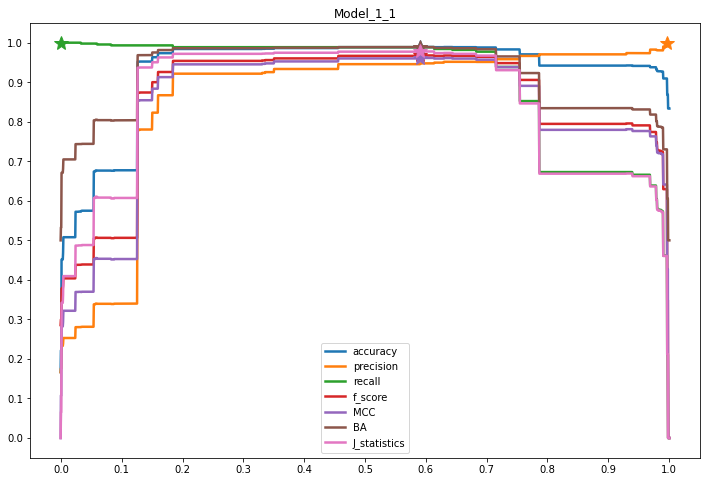

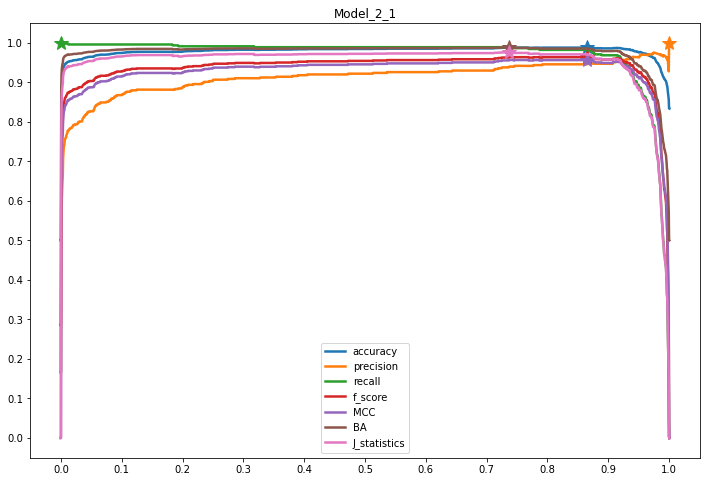

In [1274]:
viz_metrics(model_1a, model_2a)

- 7.c

Виходячи з графіків, отриманих для двох моделей, можна взяти, наприклад, поріг, за якого значення кожної відповідної метрики буде >= 0.80

{'accuracy': 0.12568909454727364, 'precision': 0.15022586293146573, 'recall': -0.0005, 'f_score': 0.12618984492246121, 'MCC': 0.12618984492246121, 'BA': 0.05408179089544772, 'J_statistics': 0.12568909454727364}


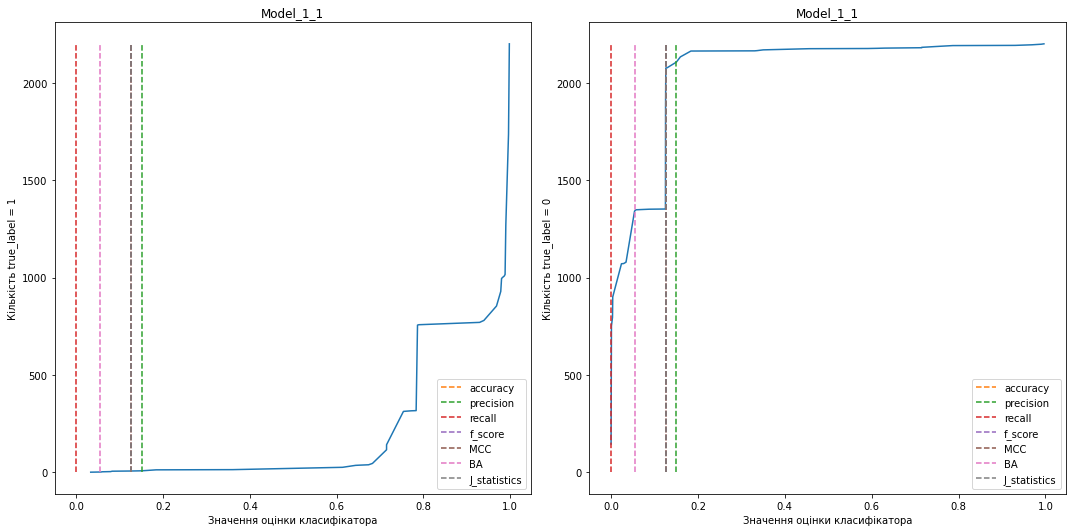

{'accuracy': 0.0010022511255627813, 'precision': 0.030546523261630813, 'recall': -0.0005, 'f_score': 0.00350600300150075, 'MCC': 0.00350600300150075, 'BA': 0.0005015007503751875, 'J_statistics': 0.0010022511255627813}


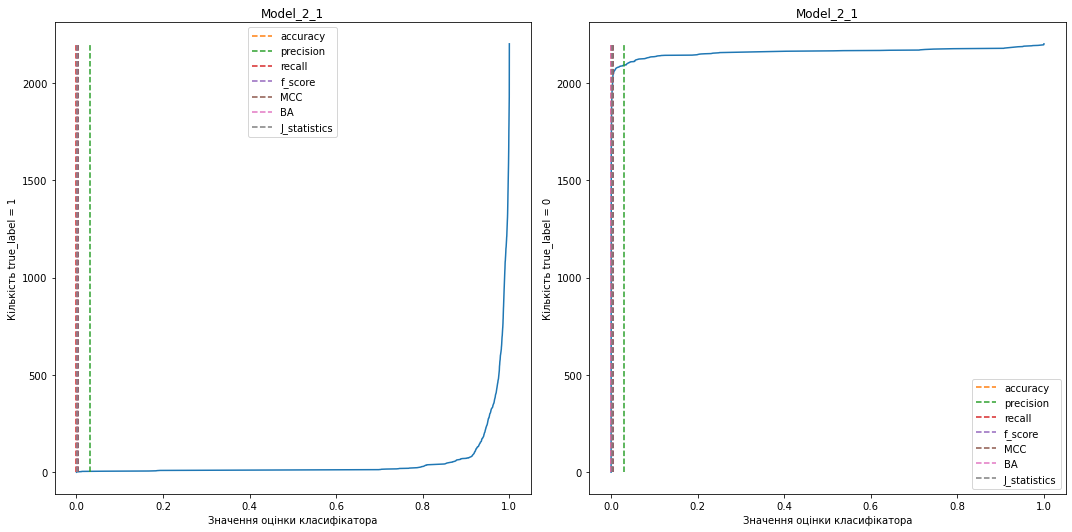

In [1275]:
plot_model(model_1a, 0.8)
plot_model(model_2a, 0.8)

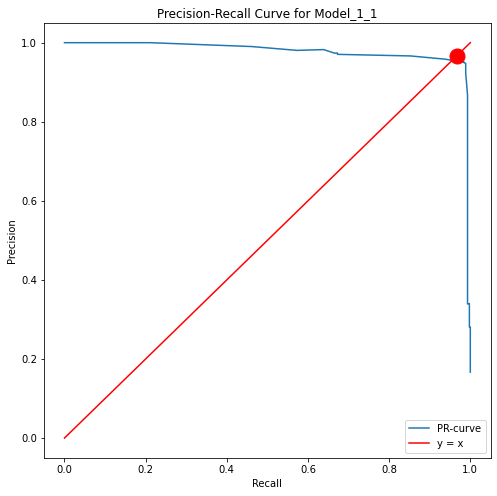

Model_1_1 PRC-AUC: 0.979


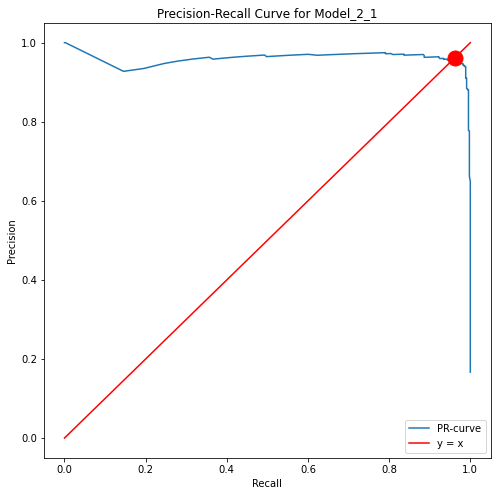

Model_2_1 PRC-AUC: 0.96


In [1276]:
plot_prc(model_1a, model_2a)

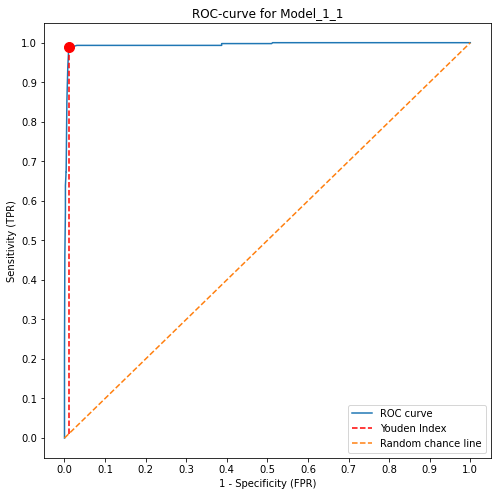

Model_1_1 ROC-AUC: 0.994


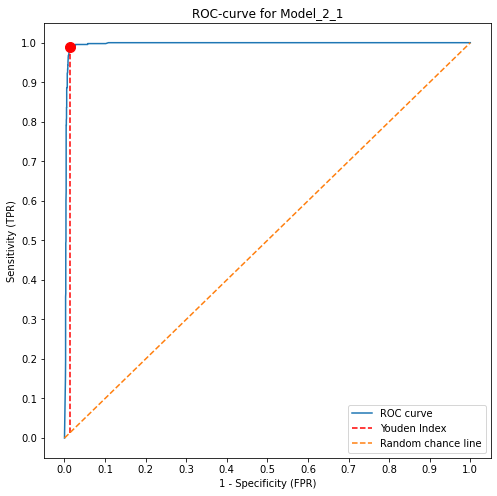

Model_2_1 ROC-AUC: 0.996


In [1277]:
plot_roc(model_1a, model_2a)

## 8. Визначити кращу модель. 

Модель №2 все ще проявляє себе помітно краще, ніж модель №1, що видно як по числових значеннях, так і по візуалізаціям метрик.

## 9. Пояснити вплив незбалансованості набору даних на прийняте рішення.

Попри те, що набір даних незбалансований, і за таких умов ROC-крива є занадто оптимістичною, показники AUC-PRC, так само як і власне AUC-ROC, для обох моделей лишаються дуже високими (що є хорошим результатом). Проте за іншими метриками (за виключенням AUC-PRC), які є стійкими до незбалансованих наборів даних (таких як MCC, Balanced Accuracy), модель №2 все ще проявляє себе помітно краще за модель №1, що видно як з числових даних, так і з відповідних візуалізацій.